1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [2]:
#the cumulative prob 𝑝𝑖 for year i is 𝑝𝑖=𝑖/(𝑁+1), 𝑁=21 
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

[0.045454545454545456, 0.09090909090909091, 0.13636363636363635, 0.18181818181818182, 0.22727272727272727, 0.2727272727272727, 0.3181818181818182, 0.36363636363636365, 0.4090909090909091, 0.45454545454545453, 0.5, 0.5454545454545454, 0.5909090909090909, 0.6363636363636364, 0.6818181818181818, 0.7272727272727273, 0.7727272727272727, 0.8181818181818182, 0.8636363636363636, 0.9090909090909091, 0.9545454545454546]
[28.09 22.46 26.65 26.65 28.79 30.19 26.19 26.75 23.34 24.16 29.75 27.93
 26.68 23.85 32.97 25.79 26.37 25.28 26.73 23.2  26.76]
[22.46, 23.2, 23.34, 23.85, 24.16, 25.28, 25.79, 26.19, 26.37, 26.65, 26.65, 26.68, 26.73, 26.75, 26.76, 27.93, 28.09, 28.79, 29.75, 30.19, 32.97]
29.32542182778957


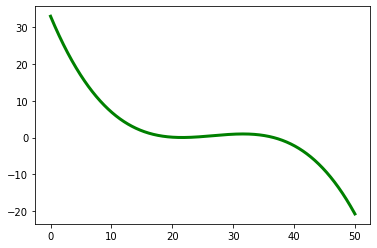

In [3]:
cprob = []
N = 21
for i in range(1, N+1):
    cpr = i/(N + 1)
    cprob.append(cpr)
print(cprob)
print(max_speeds)
speeds_sorted = sorted(max_speeds)
print(speeds_sorted)
from scipy import interpolate
spl = interpolate.UnivariateSpline(speeds_sorted, cprob, w=None)
xs = np.linspace(0, 50, 1000)
import matplotlib.pyplot as plt
plt.plot(xs, spl(xs), 'g', lw=3)
fifty_prob = 1. - 0.02
fifty_wind = spl(fifty_prob)
print(fifty_wind)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

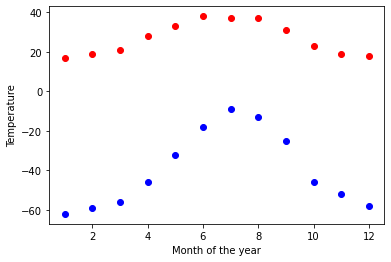

In [4]:
months = [i for i in range(1, 13)]
max_temp = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
plt.scatter(months, max_temp, color = 'r')
plt.scatter(months, min_temp, color = 'b')

plt.xlabel('Month of the year')
plt.ylabel('Temperature')

from scipy.interpolate import interp1d
# cubic_interp = interp1d(months, max_temp, kind='cubic')
# plt.plot(interpolation_time, cubic_interp, label='cubic interp', color = 'g')
f1 = interp1d(months, max_temp, kind = 'linear')
f2 = interp1d(months, max_temp, kind='cubic')
xnew = np.linspace(1, 12,30)
#plt.plot(xnew, f2(xnew))
f3 = interp1d(months, min_temp, kind='cubic')
#plt.plot(xnew, f3(xnew))
plt.show()

[ 27.94963541 -10.58169953   1.13116048   9.37491838]
[-36.71256614  25.14961938   1.14843828   4.52075118]


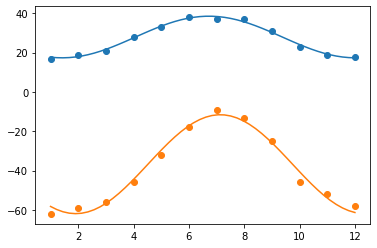

In [12]:
from scipy import optimize
def f(x, avgT, A, freq, time_offset):
    return (avgT + A * np.sin((freq * (x - time_offset)) * np.pi * 2/x.max()))

p_max, pcov_max = optimize.curve_fit(f, months, max_temp)
print(p_max)
p_min, pcov_min = optimize.curve_fit(f, months, min_temp, [-39, 20, 1, 1])
print(p_min)

xnew = np.linspace(1, 12, 50)
plt.scatter(months, max_temp, label='max')
plt.scatter(months, min_temp, label='min')

plt.plot(xnew, f(xnew, *p_max))
plt.plot(xnew, f(xnew, *p_min))

#time offset 

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [14]:
from scipy import optimize

In [24]:
def f(params):
    x, y = params
    return (4 - 2.1*(x**2) + (x**4/3))*(x**2) + x*y + (4*(y**2)-4)*(y**2)

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)


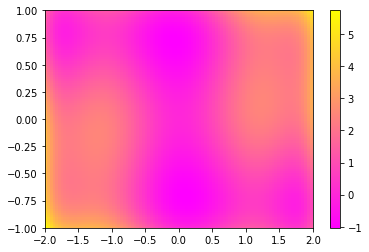

In [47]:
b = np.meshgrid(x, y, sparse=True)
from matplotlib.colors import LogNorm
import pylab
fig = plt.figure()

plt.pcolor(b[0], b[1], f(b), cmap = 'spring')
plt.colorbar()
plt.show()

In [17]:
initial_guess = [0,0]
solution = optimize.minimize(f, x0 = initial_guess, method = "Nelder-Mead")
print(solution['x'])

solution = optimize.minimize(f, x0 = initial_guess, method = "Powell")
print(solution['x'])

solution = optimize.minimize(f, x0 = initial_guess, method = "BFGS")
print(solution['x'])

[-0.08985145  0.71266538]
[-0.08984201  0.71265634]
[0. 0.]


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

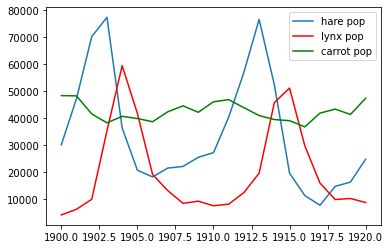

In [49]:
import pandas as pd
array = np.loadtxt("./populations.txt")
data = pd.DataFrame(array)
year = array[0:,0]
hares = array[0:,1]
lynxes = array[0:,2]
carrots = array[0:,3]
plt.plot(year, hares, label = 'hare pop')
plt.plot(year, lynxes, 'r', label = 'lynx pop')
plt.plot(year, carrots, 'g', label = 'carrot pop')
plt.legend(loc='best')

In [50]:
data.columns = ('year', 'hares', 'lynxes', 'carrots')
data

,year,hares,lynxes,carrots
0,1900.0,30000.0,4000.0,48300.0
1,1901.0,47200.0,6100.0,48200.0
2,1902.0,70200.0,9800.0,41500.0
3,1903.0,77400.0,35200.0,38200.0
4,1904.0,36300.0,59400.0,40600.0
5,1905.0,20600.0,41700.0,39800.0
6,1906.0,18100.0,19000.0,38600.0
7,1907.0,21400.0,13000.0,42300.0
8,1908.0,22000.0,8300.0,44500.0
9,1909.0,25400.0,9100.0,42100.0


[30000. 47200. 70200. 77400. 36300. 20600. 18100. 21400. 22000. 25400.
 27100. 40300. 57000. 76600. 52300. 19500. 11200.  7600. 14600. 16200.
 24700.]


10.5

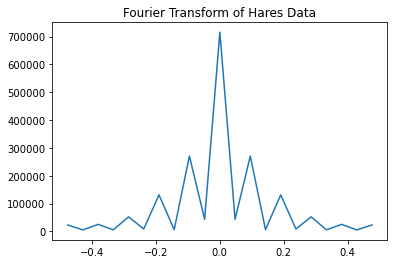

In [76]:
from scipy import fftpack
from matplotlib.colors import LogNorm
sig_fft = fftpack.fft(data['hares'].values.T)#, 20)
print(data['hares'].values.T)
power = np.abs(sig_fft)
#sig_fft = sig_fft.reshape(420)
#Vals = np.arange(0, 420)
sample_freq = fftpack.fftfreq(data.shape[0], d=1.0)
xx = np.argsort(sample_freq)
sample_freq = sample_freq[xx]
power = power[xx]
plt.plot(sample_freq, power)
# Plot the FFT power
plt.title('Fourier Transform of Hares Data')

#find peak frequency (positive frequencies)
positive_mask = np.where(sample_freq > 0)
freqs = sample_freq[positive_mask]
peak_freq = freqs[power[positive_mask].argmax()]
#peak_freq = 1/period
period = 1/peak_freq
period

0.09523809523809523
10.5 is the period of hares
0.09523809523809523
10.5 is the period of lynxes
0.09523809523809523
10.5 is the period of carrots


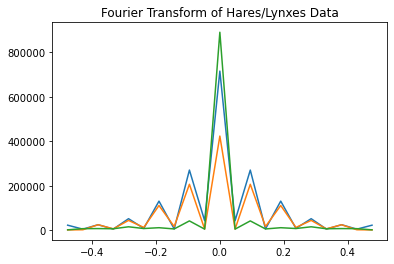

In [87]:
from scipy import fftpack
from matplotlib.colors import LogNorm
# creating a list of dataframe columns 
columns = list(data) 
  
for i in (columns[1:4]): 
    sig_fft = fftpack.fft(data[i].values.T)
#print(data['hares'].values.T)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(data.shape[0], d=1.0)
    xx = np.argsort(sample_freq)
    sample_freq = sample_freq[xx]
    power = power[xx]

# Plot the FFT power
    plt.title('Fourier Transform of Hares/Lynxes Data')
    plt.plot(sample_freq, power)

#find peak frequency (positive frequencies)
    positive_mask = np.where(sample_freq > 0)
    freqs = sample_freq[positive_mask]
    peak_freq = freqs[power[positive_mask].argmax()]
    print(peak_freq)
#peak_freq = 1/period
    period = 1/peak_freq
    print(period, 'is the period of', i)

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

In [12]:
from IPython.display import Image
img = 'moonlanding.png'
Image(url=img)

Text(0.5, 1.0, 'Original image')

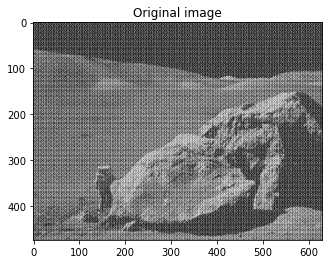

In [13]:
import pylab
sig = pylab.imread('moonlanding.png').astype(float)
plt.figure()
plt.imshow(sig, plt.cm.gray)
plt.title('Original image')


Text(0.5, 1.0, 'Fourier Transform')

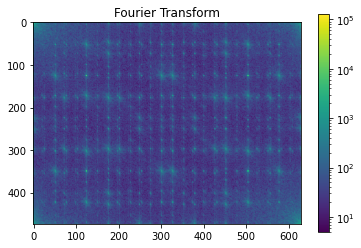

In [14]:
from scipy import fftpack
from matplotlib.colors import LogNorm
sig_fft = fftpack.fft2(sig)
plt.imshow(np.abs(sig_fft), norm= LogNorm(vmin=5))
plt.colorbar()
# Plot the FFT power
plt.title('Fourier Transform')

[[126598.45631307   -0.j          -4608.57948773-1892.46877531j
    -322.09297648  -20.27743947j ...   -906.15851028+1539.30807687j
    -322.09297648  +20.27743947j  -4608.57948773+1892.46877531j]
 [ -9421.09976601+5242.11345685j   5224.01627226-3171.7433364j
    1607.99264281+1269.42428736j ...   -677.34506193 -936.16174892j
     354.6246925 -1003.83477597j   1965.36600878-2188.05933403j]
 [ -2928.35134551+7280.91622038j  -1116.40653721+1338.31789687j
    -474.20056129 +385.4021588j  ...    239.77228866 -977.21290965j
    1582.92834328 -261.95346945j   2641.92695069 -292.09365855j]
 ...
 [  1850.57175023-2451.1786809j    -781.08067708  +13.74450084j
     377.90706254  +12.66992953j ...  -1526.78686972+1271.26210079j
   -2705.57182514-3488.5291608j    1897.40406842-2281.90925245j]
 [ -2928.35134551-7280.91622038j   2641.92695069 +292.09365855j
    1582.92834328 +261.95346945j ...  -2208.43019417  +81.807433j
    -474.20056129 -385.4021588j   -1116.40653721-1338.31789687j]
 [ -9421.0997

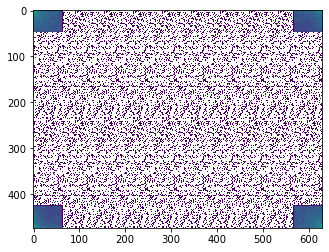

In [56]:
sig_fft2 = sig_fft.copy()
print(sig_fft2)
#no_r and no_c nu,ber rows and columns
no_r, no_c = sig_fft2.shape
#set high freq values to zero
sig_fft2[int(no_r*0.1):int(no_r*0.9)] = 0
sig_fft2[:, int(no_c*0.1):int(no_c*0.9)] = 0
plt.figure()
plt.imshow(np.abs(sig_fft2), norm= LogNorm(vmin=5))

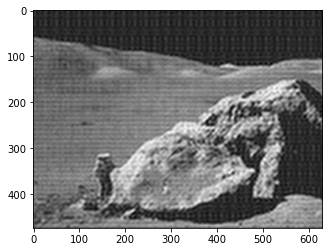

In [57]:
sig_new = fftpack.ifft2(sig_fft2).real
plt.figure()
plt.imshow(sig_new, plt.cm.gray)

(126598.45631306525-0j)
(0.047058824449777166+1.70556906099002e-16j)
[[   0.           +0.j            0.           +0.j
  -322.09297648  -20.27743947j ... -906.15851028+1539.30807687j
  -322.09297648  +20.27743947j    0.           +0.j        ]
 [   0.           +0.j            0.           +0.j
     0.           +0.j         ... -677.34506193 -936.16174892j
   354.6246925 -1003.83477597j    0.           +0.j        ]
 [   0.           +0.j            0.           +0.j
  -474.20056129 +385.4021588j  ...  239.77228866 -977.21290965j
     0.           +0.j            0.           +0.j        ]
 ...
 [   0.           +0.j         -781.08067708  +13.74450084j
   377.90706254  +12.66992953j ...    0.           +0.j
     0.           +0.j            0.           +0.j        ]
 [   0.           +0.j            0.           +0.j
     0.           +0.j         ...    0.           +0.j
  -474.20056129 -385.4021588j     0.           +0.j        ]
 [   0.           +0.j            0.           +0

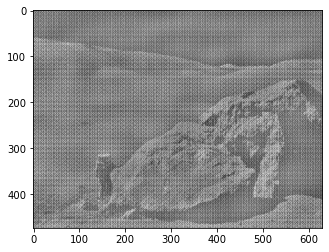

In [66]:
sig_fft3 = sig_fft.copy()
#print(sig_fft3)
print(sig_fft3.max())
print(sig_fft3.mean())
#set high freq values to zero
#sig_fft3 = np.where(sig_fft3.values > 126000, sig_fft3.replace(0))
high_values_flags = sig_fft3 > 1000# Where values are high
low_values_flags = sig_fft3 < -1000
sig_fft3[low_values_flags] = 0 
sig_fft3[high_values_flags] = 0
        
print(sig_fft3)

#plt.figure()
#plt.imshow(np.abs(sig_fft3), norm= LogNorm(vmin=5))
sig_new2 = fftpack.ifft2(sig_fft3).real
plt.figure()
plt.imshow(sig_new2, plt.cm.gray)